# Transfer Learning with Tensorflow part 1: feature extraction

In [ ]:
# Get data (10% of 10 food classes from Food101) - https://www.kaggle.com/dansbecker/food-101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip


--2023-12-22 18:46:41--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.101.207, 142.250.141.207, 142.251.2.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.101.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   110MB/s    in 1.5s    

2023-12-22 18:46:43 (110 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
import zipfile
# Unzip the downloaded file
zip=zipfile.ZipFile("/content/10_food_classes_10_percent.zip")
zip.extractall()

In [ ]:
zip.close()

## Download dataset

In [ ]:
import os
# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("/content/10_food_classes_10_percent"):
  print(f"there are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

there are 2 directories and 0 images in /content/10_food_classes_10_percent
there are 10 directories and 0 images in /content/10_food_classes_10_percent/train
there are 0 directories and 75 images in /content/10_food_classes_10_percent/train/chicken_wings
there are 0 directories and 75 images in /content/10_food_classes_10_percent/train/sushi
there are 0 directories and 75 images in /content/10_food_classes_10_percent/train/grilled_salmon
there are 0 directories and 75 images in /content/10_food_classes_10_percent/train/chicken_curry
there are 0 directories and 75 images in /content/10_food_classes_10_percent/train/hamburger
there are 0 directories and 75 images in /content/10_food_classes_10_percent/train/fried_rice
there are 0 directories and 75 images in /content/10_food_classes_10_percent/train/ice_cream
there are 0 directories and 75 images in /content/10_food_classes_10_percent/train/ramen
there are 0 directories and 75 images in /content/10_food_classes_10_percent/train/steak
th

## Preprocess data

In [ ]:
import tensorflow as tf

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Setup data inputs
IMAGE_SHAPE=(224, 224)
BATCH_SIZE=32

train_dir="/content/10_food_classes_10_percent/train/"
test_dir="/content/10_food_classes_10_percent/test/"

train_datagen=ImageDataGenerator(rescale=1/255)
test_datagen=ImageDataGenerator(rescale=1/255)

print("Training images: ")
train_data_10=train_datagen.flow_from_directory(train_dir,target_size=IMAGE_SHAPE, batch_size=BATCH_SIZE, class_mode="categorical")

print("Test images: ")
test_data_10=test_datagen.flow_from_directory(test_dir,target_size=IMAGE_SHAPE, batch_size=BATCH_SIZE, class_mode="categorical")


Training images: 
Found 750 images belonging to 10 classes.
Test images: 
Found 2500 images belonging to 10 classes.


## Setting up Callbacks

In [ ]:
import datetime
# Create TensorBoard callback (functionized to create a new one for each model)
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir=dir_name+ "/"+experiment_name+"/"+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving Tensorboard log files to: {log_dir}")
  return tensorboard_callback


#Creating Models using Tensorflow hub

In [ ]:
# compare the following two models
resnet_url="https://www.kaggle.com/models/google/resnet-v2/frameworks/TensorFlow2/variations/50-feature-vector/versions/2"

efficientnet_url="https://www.kaggle.com/models/tensorflow/efficientnet/frameworks/TensorFlow2/variations/b0-feature-vector/versions/1"

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [ ]:
# Let's make a create_model() function to create a model from a URL
def create_model(model_url, num_classes=10):
  '''
  takes a tf hub url and creates a keras sequential model with it
  '''
    # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer=hub.KerasLayer(model_url,
                                         trainable=False,
                                         name="Feature_extraction_layer",
                                         input_shape=IMAGE_SHAPE+(3,))

  model=tf.keras.Sequential()
  model.add(feature_extractor_layer)
  model.add(tf.keras.layers.Dense(num_classes, activation="softmax", name="Output_layer"))

  return model

In [ ]:
# Create Resnet and efficientnet models
resnet_model=create_model(resnet_url, num_classes=10)
efficientnet_model=create_model(efficientnet_url, num_classes=10)

In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Feature_extraction_layer (  (None, 2048)              23564800  
 KerasLayer)                                                     
                                                                 
 Output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [ ]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Feature_extraction_layer (  (None, 1280)              4049564   
 KerasLayer)                                                     
                                                                 
 Output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4062374 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049564 (15.45 MB)
_________________________________________________________________


In [ ]:
resnet_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics="accuracy") # Compile the resnet model

In [ ]:
History_resnet1=resnet_model.fit(train_data_10, epochs=5, steps_per_epoch=len(train_data_10), validation_data=test_data_10, validation_steps=len(test_data_10), callbacks=[create_tensorboard_callback(dir_name="tf_hub", experiment_name="Resnet50v2")])

Saving Tensorboard log files to: tf_hub/Resnet50v2/20231222-210905
Epoch 1/5
24/24 [==============================] - 23s 619ms/step - loss: 1.9437 - accuracy: 0.3320 - val_loss: 1.1874 - val_accuracy: 0.6340
Epoch 2/5
24/24 [==============================] - 11s 473ms/step - loss: 0.9039 - accuracy: 0.7333 - val_loss: 0.8769 - val_accuracy: 0.7244
Epoch 3/5
24/24 [==============================] - 11s 485ms/step - loss: 0.6370 - accuracy: 0.8040 - val_loss: 0.7683 - val_accuracy: 0.7484
Epoch 4/5
24/24 [==============================] - 11s 472ms/step - loss: 0.4772 - accuracy: 0.8787 - val_loss: 0.6994 - val_accuracy: 0.7696
Epoch 5/5
24/24 [==============================] - 13s 553ms/step - loss: 0.3776 - accuracy: 0.9120 - val_loss: 0.6709 - val_accuracy: 0.7820


In [ ]:
# create a function to plot loss curves

import matplotlib.pyplot as plt

# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

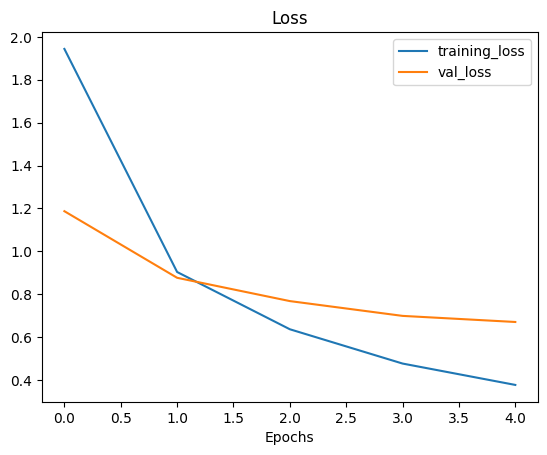

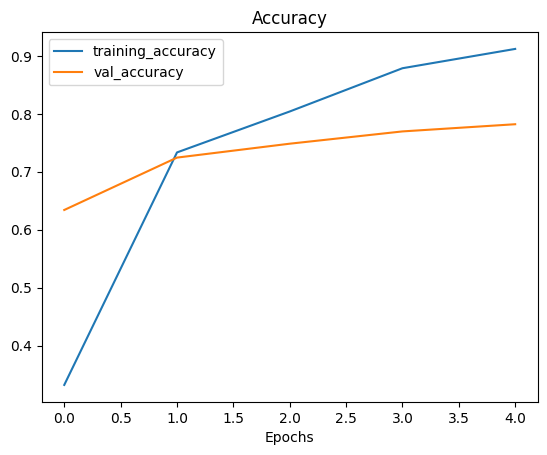

In [ ]:
#plot resnet history
plot_loss_curves(History_resnet1)

In [ ]:
efficientnet_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics="accuracy") # Compile EfficientNet model

In [ ]:
# Fit EfficientNet model to 10% of training data
History_efficientnet2=efficientnet_model.fit(train_data_10, epochs=10, steps_per_epoch=len(train_data_10), validation_data=test_data_10, validation_steps=len(test_data_10), callbacks=[create_tensorboard_callback(dir_name="tf_hub", experiment_name="Efficientnet")])

Saving Tensorboard log files to: tf_hub/Efficientnet/20231222-213402
Epoch 1/10
24/24 [==============================] - 11s 451ms/step - loss: 0.4507 - accuracy: 0.9067 - val_loss: 0.5228 - val_accuracy: 0.8608
Epoch 2/10
24/24 [==============================] - 10s 447ms/step - loss: 0.3943 - accuracy: 0.9213 - val_loss: 0.4977 - val_accuracy: 0.8680
Epoch 3/10
24/24 [==============================] - 10s 427ms/step - loss: 0.3531 - accuracy: 0.9333 - val_loss: 0.4771 - val_accuracy: 0.8660
Epoch 4/10
24/24 [==============================] - 11s 458ms/step - loss: 0.3173 - accuracy: 0.9480 - val_loss: 0.4618 - val_accuracy: 0.8704
Epoch 5/10
24/24 [==============================] - 10s 452ms/step - loss: 0.2862 - accuracy: 0.9547 - val_loss: 0.4495 - val_accuracy: 0.8716
Epoch 6/10
24/24 [==============================] - 10s 449ms/step - loss: 0.2593 - accuracy: 0.9640 - val_loss: 0.4382 - val_accuracy: 0.8740
Epoch 7/10
24/24 [==============================] - 11s 458ms/step - loss

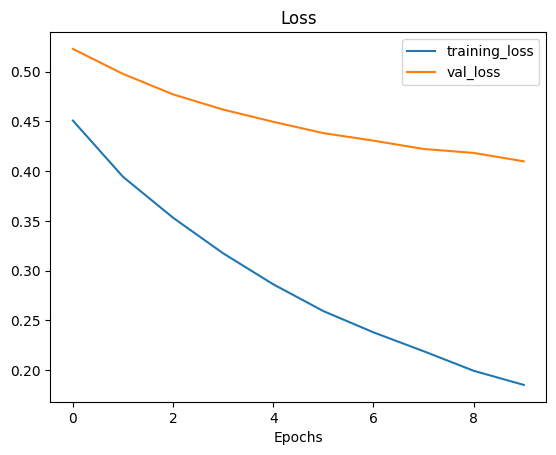

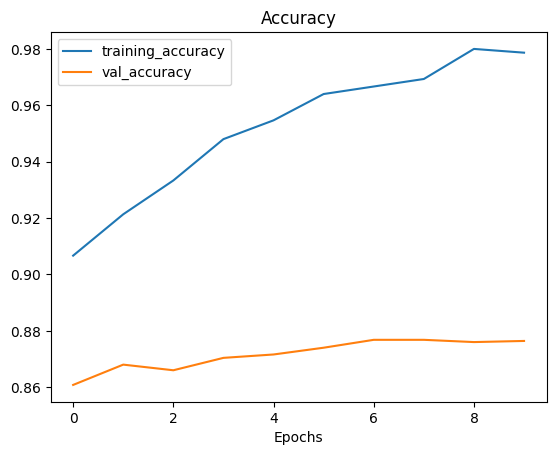

In [ ]:
plot_loss_curves(History_efficientnet2)

#Comparing models using TensorBoard

In [ ]:
!tensorboard --logdir /content/tf_hub/Resnet50v2/

2023-12-22 22:06:01.164819: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-22 22:06:01.164871: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-22 22:06:01.166103: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-22 22:06:02.187000: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to 